In [1]:
import os
import numpy as np
import mne
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pandas as pd
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from copy import deepcopy
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, read_ica
import sys
from langouEEG import *

In [3]:
init_prog(MA_n=20.0)
for i in range(1,2):
    if i<10:
        subject_name='S0'+str(i)
    else:
        subject_name='S'+str(i)
    print(subject_name)
    raw,picks,picks_str = initData(subject_name)
    initLayout(raw)
    events, event_dict=extractEvents(raw)
    filterRaw(raw, picks, ref_set_average=False, ref_channels=['M1', 'M2'])
    runICA(raw)
    epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs = epoch_RR,epoch_RF,epoch_4R,epoch_4F
    _,_,_ = getRatio_rest(epoch_4R,picks=picks_str)
    _,_,_ = getRatio_flicker(epoch_4F,picks=picks_str)
    _,_,_ = getRatio_rest_MA(epoch_4R,picks=picks_str)
    _,_,_ = getRatio_flicker_MA(epoch_4F,picks=picks_str)
    specPlot(epochs)
    superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name, MA=True)
    superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name, MA=False)
    superposFull(epoch_4R,epoch_4F,epoch_RF,subject_name)
    print(subject_name+'done')
save_ratios()
csv_transformat(type='flicker')
csv_transformat(type='rest')
csv_transformat_MA(type='flicker')
csv_transformat_MA(type='rest')

S01
/data/home/viscent/Light
/data/home/viscent/Light/Light/S01 Data.cnt
Reading 0 ... 1249599  =      0.000 ...  2499.198 secs...


/data/home/viscent/Light/LangouEEG/langouEEG.py:124: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(file_path, preload=True)
/data/home/viscent/Light/LangouEEG/langouEEG.py:127: RuntimeWarning: The unit for channel(s) Trigger has changed from V to NA.
  raw = raw.set_channel_types({'Trigger':'stim','VEO':'eog'})


Used Annotations descriptions: ['11', '12', '8', '9']
{'11': 1, '12': 2, '8': 3, '9': 4}
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 sec)



ValueError: Setting projection=True is only supported for ref_channels="average", got ['M1', 'M2'].

In [ ]:
subject_name='S11'
raw,picks,picks_str = initData(subject_name)
initLayout(raw)
events, event_dict=extractEvents(raw)
filterRaw(raw, picks, ref_set_average=False, ref_channels=['M1', 'M2'])
runICA(raw)
epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
epochs = epoch_RR,epoch_RF,epoch_4R,epoch_4F
downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_rest(epoch_4R,picks=picks_str)
downstream_mean_power,target_mean_power,upstream_mean_power=getRatio_flicker(epoch_4F,picks=picks_str)
specPlot(epochs)
superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name)
superposFull(epoch_4R,epoch_4F,epoch_RF,subject_name)

In [ ]:
psds, freqs = psd_multitaper(epoch_4F,fmin=35, fmax=45, n_jobs=8,picks=picks_str) 
superposGamma(epoch_4R,epoch_4F,epoch_RF,subject_name)

In [ ]:
psds.shape

In [ ]:
def MA(psds):
    n=20.0
    for i in range(psds.shape[0]):
        tempSum=0
        for j in range(int(n)):
            if j+i < psds.shape[0]:
                tempSum+=psds[j+i]
            else:
                n=j
                break
        psds[i]=tempSum/n
    return psds

    Using multitaper spectrum estimation with 7 DPSS windows
(9, 3, 600)
(600,)
    Using multitaper spectrum estimation with 7 DPSS windows
(9, 3, 270)
(270,)
    Using multitaper spectrum estimation with 7 DPSS windows
(5, 3, 270)
(270,)


Text(0, 0.5, 'Power spectral density (PSD) in log')

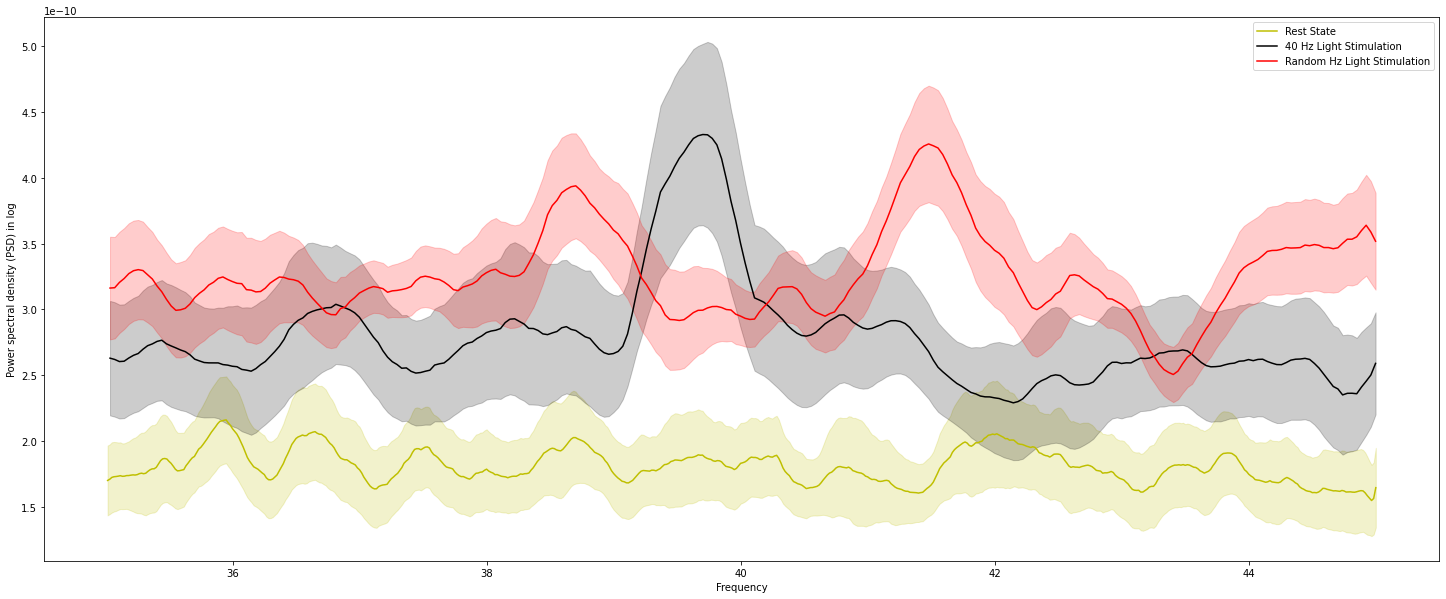

In [13]:
def doMA(psds):
    n=20.0
    for i in range(psds.shape[0]):
        tempSum=0
        for j in range(int(n)):
            if j+i < psds.shape[0]:
                tempSum+=psds[j+i]
            else:
                n=j
                break
        psds[i]=tempSum/n
    return psds
def doMA3D(psds):
    for i in range(psds.shape[0]):
        for j in range(psds.shape[1]):
            psds[i][j] = doMA(psds[i][j])
    return psds
def plot_psd_sub(epoch,ax, fmin=.1, fmax=100, n_jobs=8, color='k', alpha=.5, label='Default'):
    psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=n_jobs)
    psds = doMA3D(psds)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    print(psds_mean.shape)
    ax.plot(freqs, psds_mean, color=color, label = label)
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color=color, alpha=alpha)
    ax.legend()

fmin = 35
fmax = 45
alpha = .2
f, ax = plt.subplots(figsize=(25,10))
plot_psd_sub(ax=ax,epoch = epoch_4R, color='y', fmin=fmin, fmax=fmax, alpha=alpha, label='Rest State')
plot_psd_sub(ax=ax,epoch = epoch_4F, color='k', fmin=fmin, fmax=fmax, alpha=alpha, label='40 Hz Light Stimulation')
plot_psd_sub(ax=ax,epoch = epoch_RF, color='r', fmin=fmin, fmax=fmax, alpha=alpha, label='Random Hz Light Stimulation')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density (PSD) in log")

In [26]:
def get_minima(data):
    center = np.argmax(data)
    print(center)
    min_right = data[center]
    min_left = data[center]
    for i in range(center, data.shape[0]):
        if data[i+1] <= min_right:
            min_right = data[i+1]
        else:
            break
    for i in range(center, 0, -1):
        if data[i-1] <= min_left:
            min_left = data[i-1]
        else:
            break
    return min_left, min_right

data = [1,2,3,4,1,2,-2,1,1,90,-1,123,4,-100,1,1,2,32,31,23,1]
get_minima(np.array(data))


11


(-1, -100)

In [33]:
def get_minima(data):
    center = np.argmax(data)
    print(center)
    min_right = data[center]
    min_left = data[center]
    for i in range(center, data.shape[0]-1):
        if data[i+1] <= min_right:
            min_right = data[i+1]
        else:
            break
    for i in range(center, 0, -1):
        if data[i-1] <= min_left:
            min_left = data[i-1]
        else:
            break
    return min_left, min_right

global ratioMA_TD_all_f, ratioMA_TU_all_f, ratioMA_DU_all_f
ratioMA_TD_all_f, ratioMA_TU_all_f, ratioMA_DU_all_f = [],[],[]
    
def getRatio_flicker_MA(epoch,fmin=38.0,fmax=42.0,picks=['O1', 'OZ', 'O2']):
    psds, freqs = psd_multitaper(epoch,fmin=fmin, fmax=fmax, n_jobs=8,picks=picks) 
    # MA: 做滑动平均
    psds = doMA3D(psds)
    # psd.shape: (number of epoch, number of channel, frequency)
    f_down = 35.0
    f_low = 39.0
    f_high = 41.0
    f_upstream = 45.0
    print(psds.shape)
    num_of_epoch = psds.shape[0]
    num_of_channel = psds[0].shape[0]
    print("{0} epochs in total".format(num_of_epoch))
    print("{0} channels in total".format(num_of_channel))
    print(psds.shape)
    # average all channels
    psds = np.mean(psds, axis=1)
    # extract power in selected frequency bands
    downstream_mean_power, target_mean_power, upstream_mean_power = [],[],[]
    for i in range(0, num_of_epoch): 
        a,c = get_minima(psds[i])
        b = np.max(psds[i])
        downstream_mean_power.append(a)
        target_mean_power.append(b)
        upstream_mean_power.append(c)
    print(r'The downstream min power is:')
    print(downstream_mean_power)
    print(r'The taget band max power is:')
    print(target_mean_power)
    print(r'The upstream min power is:')
    print(upstream_mean_power)
    ratio_TD = []
    ratio_TU = []
    ratio_DU = []
    for i in range(0, len(target_mean_power)):
        TD = target_mean_power[i]/downstream_mean_power[i]
        TU = target_mean_power[i]/upstream_mean_power[i]
        DU = downstream_mean_power[i]/upstream_mean_power[i]
        ratio_TD.append(TD)
        global ratioMA_TD_all_f
        ratioMA_TD_all_f.append(TD)
        ratio_TU.append(TU)
        global ratioMA_TU_all_f
        ratioMA_TU_all_f.append(TU)
        ratio_DU.append(DU)
        global ratioMA_DU_all_f
        ratioMA_DU_all_f.append(DU)
    print(r'The target/downstream is:')
    print(ratio_TD)
    print(r'The target/upstream is:')
    print(ratio_TU)
    print(r'The downstream/upstream is:')
    print(ratio_DU)
    return downstream_mean_power,target_mean_power,upstream_mean_power
getRatio_flicker_MA(epoch_4F,fmin=35.0,fmax=45.0,picks=['O1', 'OZ', 'O2'])

    Using multitaper spectrum estimation with 7 DPSS windows
(9, 3, 270)
9 epochs in total
3 channels in total
(9, 3, 270)
119
124
168
238
128
123
129
51
269
The downstream min power is:
[4.165218639678019e-10, 2.329069573493523e-10, 3.1691802739746153e-10, 2.4781153761630704e-10, 2.0320389181506982e-10, 1.8049765089634493e-10, 2.540105695296662e-10, 4.4766874892407814e-10, 3.407443377683171e-10]
The taget band max power is:
[7.090165167905562e-10, 4.838981920042679e-10, 3.779861584334611e-10, 4.174357044853003e-10, 4.465402600469162e-10, 1.81483227820493e-10, 5.101643730649733e-10, 5.903154041262769e-10, 6.373618639382262e-10]
The upstream min power is:
[6.760068642188793e-10, 3.994663297678671e-10, 1.6271493982495318e-10, 4.1358974188650196e-10, 2.1433026474723934e-10, 1.7309126212477742e-10, 2.4567215054358464e-10, 4.124827578618736e-10, 6.373618639382262e-10]
The target/downstream is:
[1.7022312107135025, 2.0776459299944294, 1.1926937749092172, 1.6844885774916045, 2.197498561953233

([4.165218639678019e-10,
  2.329069573493523e-10,
  3.1691802739746153e-10,
  2.4781153761630704e-10,
  2.0320389181506982e-10,
  1.8049765089634493e-10,
  2.540105695296662e-10,
  4.4766874892407814e-10,
  3.407443377683171e-10],
 [7.090165167905562e-10,
  4.838981920042679e-10,
  3.779861584334611e-10,
  4.174357044853003e-10,
  4.465402600469162e-10,
  1.81483227820493e-10,
  5.101643730649733e-10,
  5.903154041262769e-10,
  6.373618639382262e-10],
 [6.760068642188793e-10,
  3.994663297678671e-10,
  1.6271493982495318e-10,
  4.1358974188650196e-10,
  2.1433026474723934e-10,
  1.7309126212477742e-10,
  2.4567215054358464e-10,
  4.124827578618736e-10,
  6.373618639382262e-10])